### The goal of this notebook is to provide a basic example of how to access the USDOT Intelligent Transportation System (ITS) Joint Program Office (JPO) Wyoming Connected Vehcile Pilot data through the Data Program Sandbox.

Objective of the notebook
- Show how to access WY CV pilot data on the sandbox
- Conduct basic analysis with the data

----

### Load key libraries for the work 
**You will need to install these libraries before running this notebook**
- boto3: AWS python library (http://boto3.readthedocs.io/en/latest/)
- pandas: Python Data Analysis Library (http://pandas.pydata.org)

In [1]:
import boto3
import pandas as pd

### Create session and client variable for accessing S3

In [2]:
session = boto3.Session()
client = session.client('s3')

### List subfolders to determine which hours data was received on Nov 20

In [16]:
result =  client.list_objects(Bucket = 'usdot-its-cvpilot-public-data', Delimiter='/', Prefix='wydot/BSM/2017/11/20/')

print(len(result.get('CommonPrefixes')))

if result.get('CommonPrefixes') is not None:
    for o in result.get('CommonPrefixes'):
        print ('subfolder : ', o.get('Prefix'))
else:
    print('No folder found for that prefix')

2
subfolder :  wydot/BSM/2017/11/20/12/
subfolder :  wydot/BSM/2017/11/20/13/


### Function for pulling file keys from the AWS S3 bucket

In [15]:
def dir_keys(client, bucket, prefix='', filekeys=[]):
    """
    Lists all file keys from a given prefix in an S3 bucket.  If no prefix is given all file keys are returned

    :param client: S3 connection object
    :param bucket: Name of bucket to search
    :param prefix: Prefix for a given folder
    :param filekeys: list for filekeys
    :return: updated filekey list with added files from search
    """
    paginator = client.get_paginator('list_objects_v2')
    for result in paginator.paginate(Bucket=bucket, Delimiter='/', Prefix=prefix):
        if result.get('Contents') is not None:
            for file in result.get('Contents'):
                if file.get('Key') != 'unknownDataType':
                    filekeys.append(file.get('Key'))
        if result.get('CommonPrefixes') is not None:
            for subdir in result.get('CommonPrefixes'):
                dir_keys(client, bucket, subdir.get('Prefix'), filekeys)
    return filekeys


### Pull all file keys for Nov 20 and determine the number of files

In [17]:
filekeys = dir_keys(client, 'usdot-its-cvpilot-public-data', 'wydot/BSM/2017/11/20/')
print('Total number of files:', str(len(filekeys)))

Total number of files: 94


### Create local directory and download files to do analysis on

In [18]:
# Create local directory
import os
cwd = os.getcwd()
local_directory = cwd + os.sep + 'tmp' + os.sep
if not os.path.exists(local_directory):
    os.makedirs(local_directory)

# Download Files
for file in filekeys:
    client.download_file('usdot-its-cvpilot-public-data', file, local_directory + file.split('/')[-1])
print('{} Files loaded to {}'.format(str(len(os.listdir(local_directory))), '/tmp/'))

94 Files loaded to /tmp/


### Look at one of the raw JSON files

In [22]:
with open("./tmp/wydot-filtered-bsm-1511788035889.json") as in_f:
    for line in in_f:
        print(line)

{"metadata":{"logFileName":"bsmTx_1511786692_fe80::226:adff:fe05:14c1.csv","recordType":"bsmTx","payloadType":"us.dot.its.jpo.ode.model.OdeBsmPayload","serialId":{"streamId":"5df4d384-dae1-4dcc-b662-95cd7e7bde5f","bundleSize":1,"bundleId":4096,"recordId":2,"serialNumber":0},"odeReceivedAt":"2017-11-27T12:50:16.377Z[UTC]","schemaVersion":3,"recordGeneratedAt":"2017-11-20T12:13:36.398Z[UTC]","recordGeneratedBy":"OBU","validSignature":true,"sanitized":true},"payload":{"dataType":"us.dot.its.jpo.ode.plugin.j2735.J2735Bsm","data":{"coreData":{"msgCnt":66,"id":"3DEF0000","secMark":36400,"position":{"latitude":41.1135612,"longitude":-104.8557380,"elevation":1856.8},"accelSet":{"accelYaw":0.00},"accuracy":{"semiMajor":1.90,"semiMinor":2.90},"transmission":"NEUTRAL","speed":19.44,"heading":259.7250,"brakes":{"wheelBrakes":{"leftFront":false,"rightFront":false,"unavailable":true,"leftRear":false,"rightRear":false},"traction":"unavailable","abs":"unavailable","scs":"unavailable","brakeBoost":"una

### Reformat it to make it easier to view

In [23]:
import pprint
import json
data = json.loads(open("./tmp/wydot-filtered-bsm-1511788035889.json").read())
pprint.pprint(data)

{'metadata': {'logFileName': 'bsmTx_1511786692_fe80::226:adff:fe05:14c1.csv',
              'odeReceivedAt': '2017-11-27T12:50:16.377Z[UTC]',
              'payloadType': 'us.dot.its.jpo.ode.model.OdeBsmPayload',
              'recordGeneratedAt': '2017-11-20T12:13:36.398Z[UTC]',
              'recordGeneratedBy': 'OBU',
              'recordType': 'bsmTx',
              'sanitized': True,
              'schemaVersion': 3,
              'serialId': {'bundleId': 4096,
                           'bundleSize': 1,
                           'recordId': 2,
                           'serialNumber': 0,
                           'streamId': '5df4d384-dae1-4dcc-b662-95cd7e7bde5f'},
              'validSignature': True},
 'payload': {'data': {'coreData': {'accelSet': {'accelYaw': 0.0},
                                   'accuracy': {'semiMajor': 1.9,
                                                'semiMinor': 2.9},
                                   'brakes': {'abs': 'unavailable',
          

### Combine the JSON files into a single JSON file

In [24]:
import glob

read_files = glob.glob(local_directory + "*.json")
with open(local_directory + "merged_file.json", "w") as outfile:
    data = []
    for f in read_files:
        data.append(open(f, "r").read())
    outfile.write("[" + ','.join(data[1:]) + "]")

### Load file into data structure
*Data is in J2735 format http://standards.sae.org/j2735_201603/*

In [27]:
from pandas.io.json import json_normalize

file_json = json.load(open(local_directory + "merged_file.json","r"))

result = json_normalize(data=file_json, meta=['metadata', ['payload', 'data']])
result.head()

,metadata.logFileName,metadata.odeReceivedAt,metadata.payloadType,metadata.recordGeneratedAt,metadata.recordGeneratedBy,metadata.recordType,metadata.sanitized,metadata.schemaVersion,metadata.serialId.bundleId,metadata.serialId.bundleSize,...,payload.data.coreData.position.elevation,payload.data.coreData.position.latitude,payload.data.coreData.position.longitude,payload.data.coreData.secMark,payload.data.coreData.size.length,payload.data.coreData.size.width,payload.data.coreData.speed,payload.data.coreData.transmission,payload.data.partII,payload.dataType
0,bsmTx_1511786692_fe80::226:adff:fe05:14c1.csv,2017-11-27T12:50:16.377Z[UTC],us.dot.its.jpo.ode.model.OdeBsmPayload,2017-11-20T12:14:06.393Z[UTC],OBU,bsmTx,True,3,4096,1,...,1865.7,41.115620,-104.862368,6400,1190,490,22.68,NEUTRAL,"[{'id': 'VehicleSafetyExtensions', 'value': {'...",us.dot.its.jpo.ode.plugin.j2735.J2735Bsm
1,bsmTx_1511786692_fe80::226:adff:fe05:14c1.csv,2017-11-27T12:50:16.377Z[UTC],us.dot.its.jpo.ode.model.OdeBsmPayload,2017-11-20T12:14:35.797Z[UTC],OBU,bsmTx,True,3,4096,1,...,1872.0,41.117003,-104.870628,35800,1190,490,24.86,NEUTRAL,"[{'id': 'VehicleSafetyExtensions', 'value': {'...",us.dot.its.jpo.ode.plugin.j2735.J2735Bsm
2,bsmTx_1511786692_fe80::226:adff:fe05:14c1.csv,2017-11-27T12:50:16.377Z[UTC],us.dot.its.jpo.ode.model.OdeBsmPayload,2017-11-20T12:15:03.496Z[UTC],OBU,bsmTx,True,3,4096,1,...,1885.6,41.116972,-104.878669,3500,1190,490,23.62,NEUTRAL,"[{'id': 'VehicleSafetyExtensions', 'value': {'...",us.dot.its.jpo.ode.plugin.j2735.J2735Bsm
3,bsmTx_1511786692_fe80::226:adff:fe05:14c1.csv,2017-11-27T12:50:16.377Z[UTC],us.dot.its.jpo.ode.model.OdeBsmPayload,2017-11-20T12:15:36.395Z[UTC],OBU,bsmTx,True,3,4096,1,...,1900.8,41.116942,-104.887766,36400,1190,490,24.30,NEUTRAL,"[{'id': 'VehicleSafetyExtensions', 'value': {'...",us.dot.its.jpo.ode.plugin.j2735.J2735Bsm
4,bsmTx_1511786692_fe80::226:adff:fe05:14c1.csv,2017-11-27T12:50:16.377Z[UTC],us.dot.its.jpo.ode.model.OdeBsmPayload,2017-11-20T12:16:06.394Z[UTC],OBU,bsmTx,True,3,4096,1,...,1903.9,41.116909,-104.896964,6400,1190,490,27.38,NEUTRAL,"[{'id': 'VehicleSafetyExtensions', 'value': {'...",us.dot.its.jpo.ode.plugin.j2735.J2735Bsm


### Do some basic analysis on the speed

In [28]:
result['payload.data.coreData.speed'].describe()

count    93.000000
mean     25.503656
std       4.656846
min       5.620000
25%      22.380000
50%      27.020000
75%      28.600000
max      33.380000
Name: payload.data.coreData.speed, dtype: float64

### Convert time by removing UTC and setting to time value

In [31]:
result['metadata.recordGeneratedAt']= result['metadata.recordGeneratedAt'].str[:-5]
result['metadata.recordGeneratedAt'] = pd.to_datetime(result['metadata.recordGeneratedAt'])
result['metadata.recordGeneratedAt']

0    2017-11-20 12:14:06.393
1    2017-11-20 12:14:35.797
2    2017-11-20 12:15:03.496
3    2017-11-20 12:15:36.395
4    2017-11-20 12:16:06.394
5    2017-11-20 12:16:36.399
6    2017-11-20 12:17:06.392
7    2017-11-20 12:17:36.391
8    2017-11-20 12:18:06.386
9    2017-11-20 12:18:36.388
10   2017-11-20 12:19:03.225
11   2017-11-20 12:19:36.389
12   2017-11-20 12:20:06.395
13   2017-11-20 12:20:36.386
14   2017-11-20 12:21:06.424
15   2017-11-20 12:21:36.395
16   2017-11-20 12:22:04.396
17   2017-11-20 12:22:36.391
18   2017-11-20 12:23:06.394
19   2017-11-20 12:23:36.390
20   2017-11-20 12:24:06.398
21   2017-11-20 12:24:36.386
22   2017-11-20 12:25:36.390
23   2017-11-20 12:26:06.400
24   2017-11-20 12:26:36.394
25   2017-11-20 12:27:06.395
26   2017-11-20 12:27:36.396
27   2017-11-20 12:28:06.395
28   2017-11-20 12:28:36.394
29   2017-11-20 12:29:06.393
               ...          
63   2017-11-20 12:48:06.394
64   2017-11-20 12:48:32.200
65   2017-11-20 12:55:01.000
66   2017-11-2

### Plot time vs speed

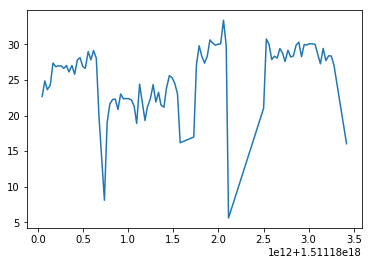

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(result['metadata.recordGeneratedAt'], result['payload.data.coreData.speed'])